In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

filepath = r"C:\Users\vansh\AI and ML reading material\MakeMore-Implementing NLP models\names.txt"

In [2]:
#read in the dataset
words = open(filepath, 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
print("The total number of words in the dataset are: ",len(words))

The total number of words in the dataset are:  32033


In [4]:
#build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i:c for c, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
#build the dataset
block_size = 3 #context_length

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape), print(Y.shape)

    return X, Y

import random
random.seed(3125)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182619, 3])
torch.Size([182619])
torch.Size([22804, 3])
torch.Size([22804])
torch.Size([22723, 3])
torch.Size([22723])


In [6]:
#utility function we will use later when xomparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt==t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}")

In [7]:
n_embed = 10 #the dimensionality of the character embedding vectors
n_hidden = 64 # the number of hidden layer of the MLP

g = torch.Generator().manual_seed(876543)
C = torch.randn((vocab_size, n_embed), generator=g)
#layer 1
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) * (5/3)/(n_embed * block_size)**0.5
b1 = torch.randn(n_hidden, generator=g) * 0.1 # using b1 just for fun it's useless
#layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

#BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

# many parameters have been initialized in non-standard ways
# because sometimes initializing with (say) all zeros could mask an 
# incorrect implementation of the backward pass

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [8]:
batch_size = 32
n=batch_size
#construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [12]:
#forward pass, "chunkated" into smaller steps that are possible to backward one at a time
emb = C[Xb] # get the embeddings of the training samples of the batch
embcat = emb.view(emb.shape[0], -1) # change the shape of embedding vector as (batch_size, input_features)
# Linear layer 1
hprebn = embcat @ W1 + b1
#batch norm layer
bnmeani = (1/n)*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani

# to caluclate variance 
bndiff2 = bndiff**2 # calcualte the square
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) #Bessel's correction = dividing by n-1 not n
bnvar_inv = (bnvar + 1e-5)**-0.5 #variance

bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
#Non-Linearity
h = torch.tanh(hpreact) #hidden layer
#Linear layer 2
logits = h @ W2 + b2
#cross entropy loss(same as F.cross_entropy(logits, Yb))
logits_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logits_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

#PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logits_maxes, logits, h, hpreact, bnraw,
          bnvar, bnvar_inv, bndiff, bndiff2, hprebn, bnmeani, embcat
          , emb]:
    t.retain_grad()
loss.backward()
loss




tensor(3.3696, grad_fn=<NegBackward0>)

In [10]:
dprobs.shape, counts.shape

NameError: name 'dprobs' is not defined

In [ ]:
# Backpropping through the whole thing manually

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]
 
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logits_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [13]:
#Earlier we were moving through each of the steps of cross entropy one by one 
#which made our job very hectic. Now we will apply backpropogation directly to
#the cross entropy formula

#cross entropy loss(same as F.cross_entropy(logits, Yb))
#logits_maxes = logits.max(1, keepdim=True).values
#norm_logits = logits - logits_maxes
#counts = norm_logits.exp()
#counts_sum = counts.sum(1, keepdim=True)
#counts_sum_inv = counts_sum**-1
#probs = counts * counts_sum_inv
#logprobs = probs.log()
#loss = -logprobs[range(n), Yb].mean()

loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.369607448577881 diff: 2.384185791015625e-07


In [15]:
#backward pass
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n #for batch normailzation

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-09


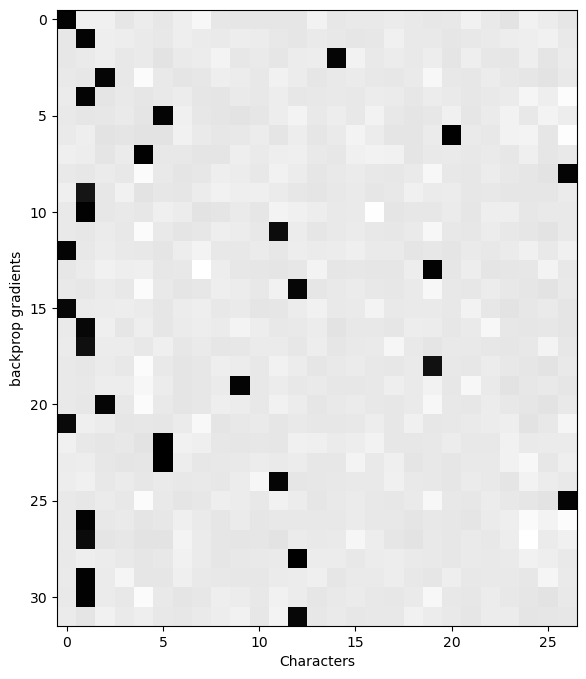

In [17]:
plt.figure(figsize = (8,8))
plt.xlabel("Characters")
plt.ylabel("backprop gradients")
plt.imshow(dlogits.detach(), cmap='gray')
